Setup and Data Collection


In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Used for creating clear tables/metrics

# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
# Set this path to your new balanced dataset folder
data_dir = Path(r'D:\YV\DSGP-IIT\disease and pest detection\Augmented_for_ml')

# Set the TARGET_COUNT used in your augmentation script for comparison
TARGET_COUNT = 1300

# ==============================================================================
# 2. Collect Counts and Metrics
# ==============================================================================

class_counts = {}
total_images = 0

# Get a list of all class folders
class_folders = [d for d in data_dir.iterdir() if d.is_dir()]

# Iterate and count images in each folder
for class_path in class_folders:
    class_name = class_path.name
    # Use glob('*') to count all files in the directory
    count = len(list(class_path.glob('*')))
    class_counts[class_name] = count
    total_images += count

print("--- Class Distribution Analysis (Post-Augmentation) ---")
print(f"Total Images in Dataset: {total_images}")
print(f"Goal Count per Class: {TARGET_COUNT}")

--- Class Distribution Analysis (Post-Augmentation) ---
Total Images in Dataset: 39418
Goal Count per Class: 1300


Metrics Table

In [2]:
# Create a DataFrame for easy metric calculation and display
df_metrics = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Final Count'])

# Calculate the deviation from the target
df_metrics['Target Count'] = TARGET_COUNT
df_metrics['Difference'] = df_metrics['Final Count'] - df_metrics['Target Count']

# Calculate the percentage of total images
df_metrics['% of Total'] = (df_metrics['Final Count'] / total_images) * 100

# Sort by count for better comparison
df_metrics = df_metrics.sort_values(by='Final Count', ascending=False)

# Display the metrics table
print("\n--- Balance Metrics Table ---")
# Use Markdown formatting to display the table clearly in the notebook
display(df_metrics.style.format({'Final Count': '{:,}', 'Target Count': '{:,}', '% of Total': '{:.2f}%'}))


--- Balance Metrics Table ---


,Final Count,Target Count,Difference,% of Total
Anthracnose,"3,435","1,300",2135,8.71%
bird eye spot,"3,394","1,300",2094,8.61%
Red Rust,"3,306","1,300",2006,8.39%
Thrips,"3,287","1,300",1987,8.34%
Tea leaf blight,"2,759","1,300",1459,7.00%
algal leaf,"2,725","1,300",1425,6.91%
Tea red scab,"2,592","1,300",1292,6.58%
gray light,"2,428","1,300",1128,6.16%
Tea red leaf spot,"2,427","1,300",1127,6.16%
white spot,"2,395","1,300",1095,6.08%


Visualization

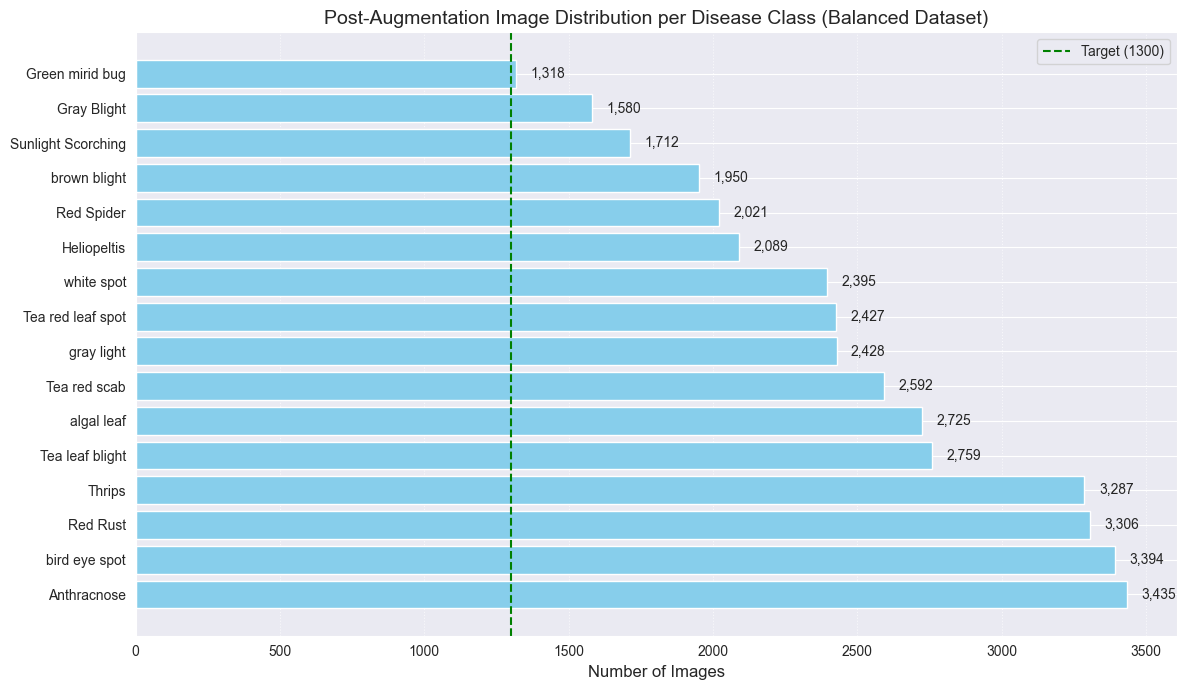

In [3]:
# Prepare data for plotting
classes = list(df_metrics.index)
counts = df_metrics['Final Count'].tolist()
y_pos = np.arange(len(classes))

# Define colors based on target count
colors = ['lightcoral' if count < TARGET_COUNT else 'skyblue' for count in counts]

plt.figure(figsize=(12, 7))
bars = plt.barh(y_pos, counts, align='center', color=colors)

# Add a vertical line to represent the target count
plt.axvline(TARGET_COUNT, color='green', linestyle='--', linewidth=1.5, label=f'Target ({TARGET_COUNT})')

plt.yticks(y_pos, classes)
plt.xlabel('Number of Images', fontsize=12)
plt.title('Post-Augmentation Image Distribution per Disease Class (Balanced Dataset)', fontsize=14)
plt.legend()
plt.grid(axis='x', linestyle=':', alpha=0.7)

# Add data labels to the bars
for bar in bars:
    plt.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():,}', va='center')

plt.tight_layout()
plt.show()


# Assuming 'history' is the object returned by model.fit()
def plot_training_history(history):
    # --- Plot 1: Loss ---
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)


# Example usage (assuming class labels are ['Healthy', 'Blister Blight', 'Rust']):
# plot_confusion_matrix(y_true, y_pred_classes, class_labels=['Healthy', 'BB', 'Rust'])


Feature Extraction Script(VGG16 transfer learning)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from pathlib import Path
import numpy as np
from tqdm import tqdm
import os

# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================

# Directory containing the balanced dataset (output of your augmentation script)
data_dir = Path(r'D:\YV\DSGP-IIT\disease and pest detection\augmented_for_ml')
IMAGE_SIZE = (224, 224)

# Location to save the final feature arrays
save_location = data_dir.parent

# ==============================================================================
# 2. SETUP VGG16 AS THE FEATURE EXTRACTOR
# ==============================================================================

# Load VGG16 pre-trained on ImageNet weights
# include_top=False tells Keras to remove the final classification layers,
# leaving only the deep feature-extracting layers.
print("Loading VGG16 Feature Extractor...")
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)

# Create the final feature extractor model structure:
# 1. Base VGG16 Layers (extracts features)
# 2. GlobalAveragePooling2D (flattens the feature maps into a 1D vector of fixed size)
feature_extractor = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D()
])


# Data structures to store the results
features_list = []
labels_list = []
class_to_index = {}
current_index = 0

# ==============================================================================
# 3. EXTRACT FEATURES FROM BALANCED IMAGES
# ==============================================================================
print("\n--- Starting Feature Extraction Process (Time-consuming step) ---")

for class_path in data_dir.iterdir():
    if class_path.is_dir():
        class_name = class_path.name
        print(f"Processing class: {class_name}")

        # Map class name to a numerical index (0, 1, 2, ...)
        if class_name not in class_to_index:
            class_to_index[class_name] = current_index
            current_index += 1

        label = class_to_index[class_name]

        # Loop through all image files in the class folder
        image_files = list(class_path.glob('*'))

        # Use tqdm for a visible progress bar in your notebook
        for img_path in tqdm(image_files):
            try:
                # Load and preprocess the image
                img = image.load_img(img_path, target_size=IMAGE_SIZE)
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0) # Add batch dimension

                # Apply VGG16-specific preprocessing
                img_array = tf.keras.applications.vgg16.preprocess_input(img_array)

                # Extract features using the model
                features = feature_extractor.predict(img_array, verbose=0)

                # Append the flattened feature vector and label
                features_list.append(features.flatten())
                labels_list.append(label)
            except Exception as e:
                print(f"Skipping corrupted file {img_path.name} in {class_name}: {e}")

# Convert lists to NumPy arrays
X = np.array(features_list)
y = np.array(labels_list)

# ==============================================================================
# 4. SAVE RESULTS
# ==============================================================================

# Save the features and labels to disk for final model training
np.save(save_location / 'extracted_features_X.npy', X)
np.save(save_location / 'extracted_labels_y.npy', y)
np.save(save_location / 'class_mapping.npy', class_to_index)

print(f"\nFeature Extraction Complete.")
print(f"Shape of Features (X): {X.shape} (Total Images x Feature Vector Size)")
print(f"Shape of Labels (y): {y.shape}")
print(f"Features saved successfully to: {save_location.resolve()}")

Correlation Matrix for Extracted features

Features Loaded. Shape of X: (39418, 512)

Applying PCA to reduce feature dimensions from 512 to 20...
PCA Variance Explained by 20 components: 0.75

Calculating Correlation Matrix...


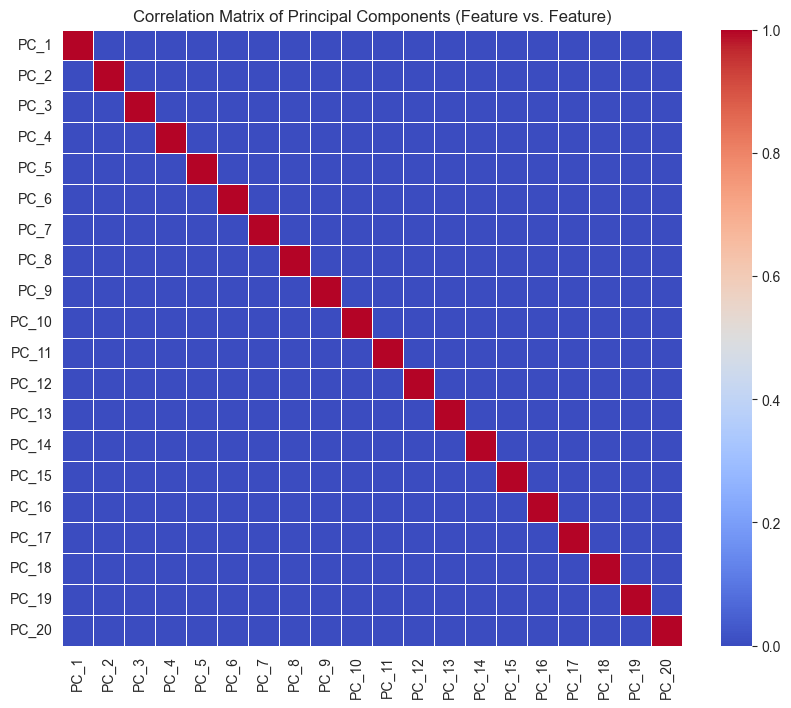

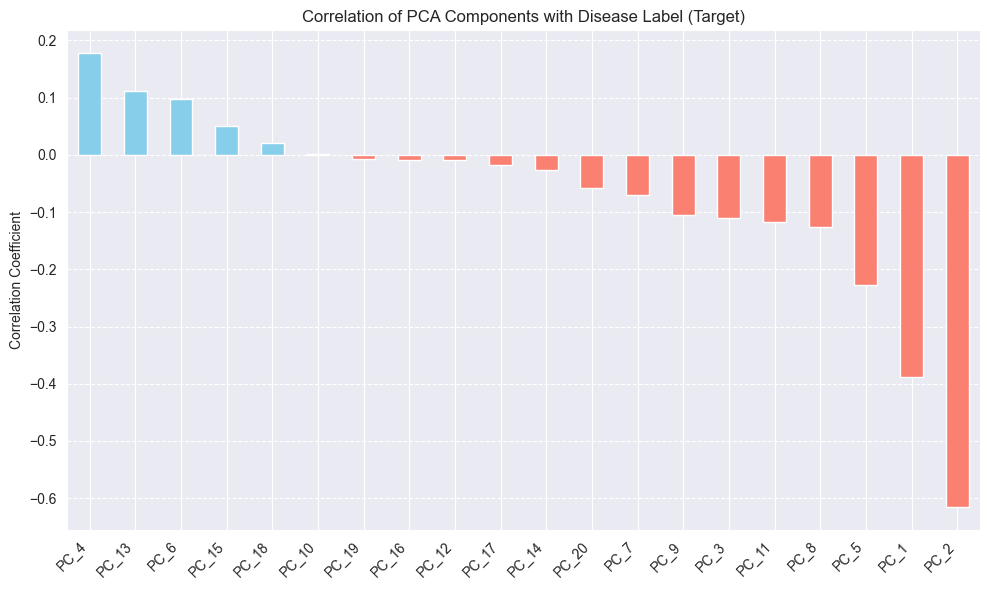

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA # Required for better visualization

# ==============================================================================
# 1. CONFIGURATION AND DATA LOADING
# ==============================================================================

# Location where features and labels were saved
data_save_location = Path(r'D:\YV\DSGP-IIT\disease and pest detection')

# Load the saved feature arrays
X = np.load(data_save_location / 'extracted_features_X.npy')
y = np.load(data_save_location / 'extracted_labels_y.npy')
class_map = np.load(data_save_location / 'class_mapping.npy', allow_pickle=True).item()
index_to_class = {v: k for k, v in class_map.items()}

print("Features Loaded. Shape of X:", X.shape)

# ==============================================================================
# 2. DIMENSIONALITY REDUCTION (CRUCIAL STEP FOR VISUALIZATION)
# ==============================================================================

# The VGG16 features (X) have a very high dimension (e.g., 512 or 2048).
# Calculating a correlation matrix on all dimensions is computationally huge and unreadable.
# We must use Principal Component Analysis (PCA) to reduce the features to a manageable number (e.g., 20 components)
# while retaining most of the variance.

N_COMPONENTS = 20 # Number of principal components to keep for visualization

print(f"\nApplying PCA to reduce feature dimensions from {X.shape[1]} to {N_COMPONENTS}...")

pca = PCA(n_components=N_COMPONENTS)
X_pca = pca.fit_transform(X)

print(f"PCA Variance Explained by {N_COMPONENTS} components: {np.sum(pca.explained_variance_ratio_):.2f}")

# Convert the PCA features and labels into a single DataFrame
feature_names = [f'PC_{i+1}' for i in range(N_COMPONENTS)]
df_features = pd.DataFrame(X_pca, columns=feature_names)
df_features['Target_Label'] = y # Add the numerical labels

# ==============================================================================
# 3. CORRELATION MATRIX CALCULATION AND VISUALIZATION
# ==============================================================================

print("\nCalculating Correlation Matrix...")

# Calculate the correlation matrix for the PCA components and the target label
correlation_matrix = df_features.corr()

# Extract only the correlation values we care about: Feature vs Feature, and Feature vs Target
# Focus on the correlations between the top 20 features and the Target_Label
target_correlations = correlation_matrix.loc[feature_names, 'Target_Label'].sort_values(ascending=False)
feature_vs_feature_matrix = correlation_matrix.iloc[:-1, :-1] # Exclude the target row/column

# --- VISUALIZATION 1: Feature vs Feature Correlation Heatmap ---
plt.figure(figsize=(10, 8))
#
sns.heatmap(
    feature_vs_feature_matrix,
    annot=False, # Set to False as 20 values is still too many to read
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5
)
plt.title('Correlation Matrix of Principal Components (Feature vs. Feature)')
plt.show()

# --- VISUALIZATION 2: Feature vs Target Correlation Bar Plot ---
plt.figure(figsize=(10, 6))
target_correlations.plot(kind='bar', color=target_correlations.apply(lambda x: 'salmon' if x < 0 else 'skyblue'))
plt.title('Correlation of PCA Components with Disease Label (Target)')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()